# **Downloading and importing required libraries**

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.6 MB/s eta 0:00:00


In [ ]:
!pip install langdetect

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993243 sha256=ddcb0ede13a07fd4edacee567162d338909807eb4bada09dc098b8a37260ec33
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from textblob import TextBlob
import nltk
import spacy
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer

# **observing data**

In [ ]:
data = pd.read_csv("/content/drive/2019_5-6-7data.csv")
datacp = data.copy()

In [ ]:
datacp

,date,body
0,2019-05-01,Coinbase requires a certain amount of confirma...
1,2019-05-01,Roger Ver (or simply Roger): collective noun. ...
2,2019-05-01,I watched the video 2 times. best bitcoin ad e...
3,2019-05-01,"Nano is my go to for P2P crypto right now, it'..."
4,2019-05-01,&gt;Bakkt delays may have been a blessing in d...
...,...,...
152602,2019-07-30,"In the end, you gotta spend money to get bitco..."
152603,2019-07-30,It's not as simple as that.\n\nI wrote an opin...
152604,2019-07-30,Buy Bitcoin.
152605,2019-07-30,"While very fucking cool, I wish it was more in..."


# **data preprocessing**

detecting and discarding comments and posts written in different languages.

In [ ]:
from langdetect import detect
def filter_english_comments(comments):
  try:
    if detect(comments) == "en":
      return "eng"
    else:
      return "other_lang"
  except:
    return True

In [ ]:
datacp["language"] = datacp["body"].apply(filter_english_comments)

In [ ]:
datacp["language"].value_counts()

eng           150122
other_lang      2484
True               1
Name: language, dtype: int64

In [ ]:
datacp = datacp.drop(index=datacp[datacp["language"]=="other_lang"].index,axis=1)

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm')

In [ ]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

Since I will do sentiment analysis with 2 different models, I applied separate preprocessing steps for 2 models.

In [ ]:
def cleaning_textblob(comment):
  comment = remove_emoji(comment)  # Remove emojis
  comment = re.sub(r'\W+|\d+', ' ', comment) # Removing special characters and numbers
  comment = re.sub(r'\W', ' ', comment) # Removing non-alphanumeric characters
  comment = re.sub("#[a-zA-Z0-9]+"," ", comment) # Removing structures that start with hashtags
  comment = re.sub("\\n"," ", comment) # # Removing \\n structures
  comment = re.sub("@[\S]*"," ", comment) # Removing structures starting with @
  comment = re.sub("https?:\/\/\S+"," ", comment) # removal of link structures.
  comment = re.sub("[^a-zA-Z0-9]"," ",comment) # remove punctuation marks
  comment = re.sub(r'\s+[a-zA-Z]\s+', ' ', comment) # Remove single letter words
  comment = re.sub(r'\s+', ' ', comment) # Remove multiple spaces
  comment = re.sub("^[\s]+|[\s]+$"," ",comment) # removing spaces before and after words
  comment = comment.lower()
  # Removing stopwords
  comment = ' '.join([word for word in comment.split() if word not in stop_words])
  # Lemmatizasyon
  comment = ' '.join([lemmatizer.lemmatize(word) for word in comment.split()])
  # Removing custom names with NER (Named Entity Recognition)
  doc = nlp(comment)
  comment = ' '.join([token.text for token in doc if token.ent_type_ == ''])
  return comment


In [ ]:
def cleaning_bert(comment):
  comment = remove_emoji(comment)  # Remove emojis
  comment = re.sub("#[a-zA-Z0-9]+"," ", comment) # Removing structures that start with hashtags
  comment = re.sub("\\n"," ", comment) # Removing \\n structures
  comment = re.sub("@[\S]*"," ", comment) # Removing structures starting with @
  comment = re.sub("https?:\/\/\S+"," ", comment) # removal of link structures.
  comment = re.sub(r'\s+', ' ', comment) # Remove multiple spaces
  comment = re.sub("^[\s]+|[\s]+$"," ",comment) # removing spaces before and after words
  comment = re.sub("[^a-zA-Z0-9]"," ",comment) # remove punctuation marks
  comment = comment.lower()
  return comment

In [ ]:
datacp["clear comment"] = datacp["body"].apply(cleaning_textblob)

In [ ]:
datacp["bert_clear_comment"] = datacp["body"].apply(cleaning_bert)

## **Sentiment analysis with 2 different models**

1- TEXTBLOB

In [ ]:
def sentiment_score(comment):
  blob = TextBlob(comment)
  return blob.sentiment.polarity

In [ ]:
datacp["textblob_sentiment_score"] = datacp["clear comment"].apply(sentiment_score)

In [ ]:
def sentiment(sense):
  if sense<0:
    return "negative"
  if sense>0:
    return "positive"
  else:
    return "neutral"


In [ ]:
datacp["textblob_sentiment"] = datacp["textblob_sentiment_score"].apply(sentiment)

In [ ]:
datacp

,date,body,clear comment,language,bert_clear_comment,textblob_sentiment_score,textblob_sentiment
0,2019-05-01,Coinbase requires a certain amount of confirma...,coinbase requires certain amount confirmation ...,eng,coinbase requires a certain amount of confirma...,0.214286,positive
1,2019-05-01,Roger Ver (or simply Roger): collective noun. ...,simply roger collective noun hater bitcoin ene...,eng,roger ver (or simply roger): collective noun. ...,0.000000,neutral
2,2019-05-01,I watched the video 2 times. best bitcoin ad e...,watched video time best bitcoin ad ever,eng,i watched the video 2 times. best bitcoin ad e...,1.000000,positive
3,2019-05-01,"Nano is my go to for P2P crypto right now, it'...",go p crypto right bitcoin supposed thing bothe...,eng,"nano is my go to for p2p crypto right now, it'...",0.285714,positive
4,2019-05-01,&gt;Bakkt delays may have been a blessing in d...,delay may blessing disguise since avoided mass...,eng,&gt;bakkt delays may have been a blessing in d...,0.066667,positive
...,...,...,...,...,...,...,...
150118,2019-07-30,"In the end, you gotta spend money to get bitco...",end got ta spend money get bitcoin nano,eng,"in the end, you gotta spend money to get bitco...",0.000000,neutral
150119,2019-07-30,It's not as simple as that.\n\nI wrote an opin...,simple wrote opinion piece blog try explain ht...,eng,it's not as simple as that. i wrote an opinion...,-0.060000,negative
150120,2019-07-30,Buy Bitcoin.,buy bitcoin,eng,buy bitcoin.,0.000000,neutral
150121,2019-07-30,"While very fucking cool, I wish it was more in...",fucking cool wish informational advertising bi...,eng,"while very fucking cool, i wish it was more in...",0.350000,positive


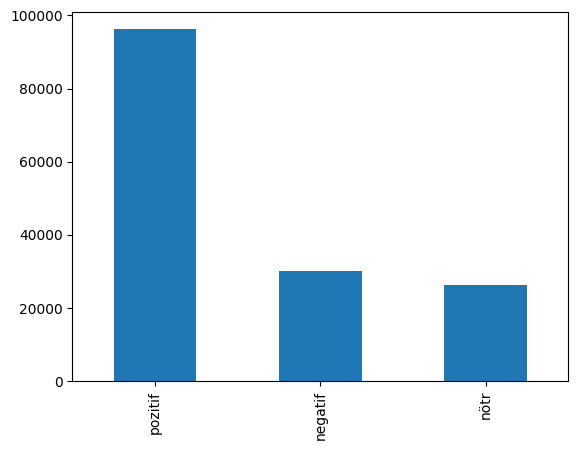

In [ ]:
datacp["text_blob_sense"].value_counts().plot(kind="bar")
plt.show()

2- BERT

The sentiment analysis model I will be using is available on the Hugging Face community page. This model has been trained on a vast dataset of 198 million tweets specifically for sentiment analysis purposes. By leveraging this pre-trained model, which has learned from a diverse range of tweets, I aim to obtain accurate and reliable sentiment predictions for the Bitcoin-related comments and posts in my analysis.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
from transformers import pipeline
sentiment_task = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, max_length=512, truncation=True)
sentiment_task("Bitcoin expensive for now.")

[{'label': 'negative', 'score': 0.48311087489128113}]

In [ ]:
def score(comment):
  return sentiment_task(comment)[0].get("label")

In [ ]:
datacp["bert_sentiment"] = datacp["bert_clear_comment"].apply(score)

In [ ]:
datacp

,date,body,clear comment,language,bert_clear_comment,textblob_sentiment_score,textblob_sentiment,bert_sentiment
0,2019-05-01,Coinbase requires a certain amount of confirma...,coinbase requires certain amount confirmation ...,eng,coinbase requires a certain amount of confirma...,0.214286,positive,neutral
1,2019-05-01,Roger Ver (or simply Roger): collective noun. ...,simply roger collective noun hater bitcoin ene...,eng,roger ver (or simply roger): collective noun. ...,0.000000,neutral,negative
2,2019-05-01,I watched the video 2 times. best bitcoin ad e...,watched video time best bitcoin ad ever,eng,i watched the video 2 times. best bitcoin ad e...,1.000000,positive,positive
3,2019-05-01,"Nano is my go to for P2P crypto right now, it'...",go p crypto right bitcoin supposed thing bothe...,eng,"nano is my go to for p2p crypto right now, it'...",0.285714,positive,negative
4,2019-05-01,&gt;Bakkt delays may have been a blessing in d...,delay may blessing disguise since avoided mass...,eng,&gt;bakkt delays may have been a blessing in d...,0.066667,positive,neutral
...,...,...,...,...,...,...,...,...
150118,2019-07-30,"In the end, you gotta spend money to get bitco...",end got ta spend money get bitcoin nano,eng,"in the end, you gotta spend money to get bitco...",0.000000,neutral,neutral
150119,2019-07-30,It's not as simple as that.\n\nI wrote an opin...,simple wrote opinion piece blog try explain ht...,eng,it's not as simple as that. i wrote an opinion...,-0.060000,negative,neutral
150120,2019-07-30,Buy Bitcoin.,buy bitcoin,eng,buy bitcoin.,0.000000,neutral,neutral
150121,2019-07-30,"While very fucking cool, I wish it was more in...",fucking cool wish informational advertising bi...,eng,"while very fucking cool, i wish it was more in...",0.350000,positive,positive


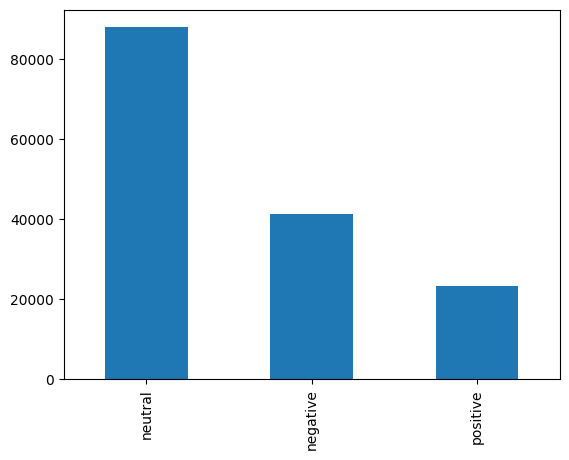

In [ ]:
datacp["bert_sentiment"].value_counts().plot(kind="bar")
plt.show()

## **relationship between sentiment analysis results and bitcoin price**

In [ ]:
btc_price = pd.read_csv("/content/drive/2019_5-6-7change&close.csv")

In [ ]:
btc_price

,date,Close_price,change
0,2019-05-01,5402.697266,51.782715
1,2019-05-02,5505.283691,102.860840
2,2019-05-03,5768.289551,262.737305
3,2019-05-04,5831.167480,61.964844
4,2019-05-05,5795.708496,-35.359863
...,...,...,...
86,2019-07-26,9870.303711,-42.823242
87,2019-07-27,9477.677734,-393.487305
88,2019-07-28,9552.860352,61.233398
89,2019-07-29,9519.145508,-29.033203


In [ ]:
result_sentiment = datacp.copy()

In [ ]:
result_sentiment

,date,body,clear comment,language,bert_clear_comment,textblob_sentiment_score,textblob_sentiment,bert_sentiment
0,2019-05-01,Coinbase requires a certain amount of confirma...,coinbase requires certain amount confirmation ...,eng,coinbase requires a certain amount of confirma...,0.214286,positive,neutral
1,2019-05-01,Roger Ver (or simply Roger): collective noun. ...,simply roger collective noun hater bitcoin ene...,eng,roger ver (or simply roger): collective noun. ...,0.000000,neutral,negative
2,2019-05-01,I watched the video 2 times. best bitcoin ad e...,watched video time best bitcoin ad ever,eng,i watched the video 2 times. best bitcoin ad e...,1.000000,positive,positive
3,2019-05-01,"Nano is my go to for P2P crypto right now, it'...",go p crypto right bitcoin supposed thing bothe...,eng,"nano is my go to for p2p crypto right now, it'...",0.285714,positive,negative
4,2019-05-01,&gt;Bakkt delays may have been a blessing in d...,delay may blessing disguise since avoided mass...,eng,&gt;bakkt delays may have been a blessing in d...,0.066667,positive,neutral
...,...,...,...,...,...,...,...,...
150118,2019-07-30,"In the end, you gotta spend money to get bitco...",end got ta spend money get bitcoin nano,eng,"in the end, you gotta spend money to get bitco...",0.000000,neutral,neutral
150119,2019-07-30,It's not as simple as that.\n\nI wrote an opin...,simple wrote opinion piece blog try explain ht...,eng,it's not as simple as that. i wrote an opinion...,-0.060000,negative,neutral
150120,2019-07-30,Buy Bitcoin.,buy bitcoin,eng,buy bitcoin.,0.000000,neutral,neutral
150121,2019-07-30,"While very fucking cool, I wish it was more in...",fucking cool wish informational advertising bi...,eng,"while very fucking cool, i wish it was more in...",0.350000,positive,positive


In [ ]:
# label encoder 
def encoder(text):
  if text=="positive":
    return 1
  elif text=="neutral":
    return 0
  else :
    return 0

In [ ]:
result_sentiment["bert_sentiment"] = result_sentiment["bert_sentiment"].apply(encoder)
result_sentiment["textblob_sentiment"] = result_sentiment["textblob_sentiment"].apply(encoder)

In [ ]:
result_sentiment["date"] = pd.to_datetime(result_sentiment["date"])
btc_price["date"] = pd.to_datetime(btc_price["date"])

In [ ]:
textblob_score = result_sentiment["textblob_sentiment"].groupby(result_sentiment["date"]).mean().reset_index()

In [ ]:
textblob_score

,date,textblob_sentiment
0,2019-05-01,0.586678
1,2019-05-02,0.610362
2,2019-05-03,0.602720
3,2019-05-04,0.584615
4,2019-05-05,0.613900
...,...,...
86,2019-07-26,0.587428
87,2019-07-27,0.569847
88,2019-07-28,0.577778
89,2019-07-29,0.588147


In [ ]:
mean_bert_score = result_sentiment["bert_sentiment"].groupby(result_sentiment["date"]).mean().reset_index()

In [ ]:
mean_bert_score 

,date,bert_sentiment
0,2019-05-01,0.135181
1,2019-05-02,0.171190
2,2019-05-03,0.168414
3,2019-05-04,0.146400
4,2019-05-05,0.143184
...,...,...
86,2019-07-26,0.140014
87,2019-07-27,0.131161
88,2019-07-28,0.135364
89,2019-07-29,0.152077


In [ ]:
sum_comment = result_sentiment["clear comment"].groupby(result_sentiment["date"]).count().reset_index()

In [ ]:
sum_comment

,date,clear comment
0,2019-05-01,1191
1,2019-05-02,1437
2,2019-05-03,1431
3,2019-05-04,1250
4,2019-05-05,1313
...,...,...
86,2019-07-26,1407
87,2019-07-27,1197
88,2019-07-28,1182
89,2019-07-29,1348


In [ ]:
result_df = pd.merge(btc_price, mean_bert_score , on="date")

In [ ]:
result_df = pd.merge(result_df, sum_comment, on="date")

In [ ]:
result_df = pd.merge(result_df, textblob_score, on="date")

In [ ]:
result_df = result_df.rename(columns={"clear comment":"sum_comment"})

In [ ]:
result_df

,date,Close_price,change,bert_sentiment,sum_comment,textblob_sentiment
0,2019-05-01,5402.697266,51.782715,0.135181,1191,0.586678
1,2019-05-02,5505.283691,102.860840,0.171190,1437,0.610362
2,2019-05-03,5768.289551,262.737305,0.168414,1431,0.602720
3,2019-05-04,5831.167480,61.964844,0.146400,1250,0.584615
4,2019-05-05,5795.708496,-35.359863,0.143184,1313,0.613900
...,...,...,...,...,...,...
86,2019-07-26,9870.303711,-42.823242,0.140014,1407,0.587428
87,2019-07-27,9477.677734,-393.487305,0.131161,1197,0.569847
88,2019-07-28,9552.860352,61.233398,0.135364,1182,0.577778
89,2019-07-29,9519.145508,-29.033203,0.152077,1348,0.588147


I examined the correlations between sentiment, Bitcoin price, and comment activity by visualizing them in a heatmap. This analysis provides a comprehensive overview of how these factors interrelate.

In [ ]:
import seaborn as sns

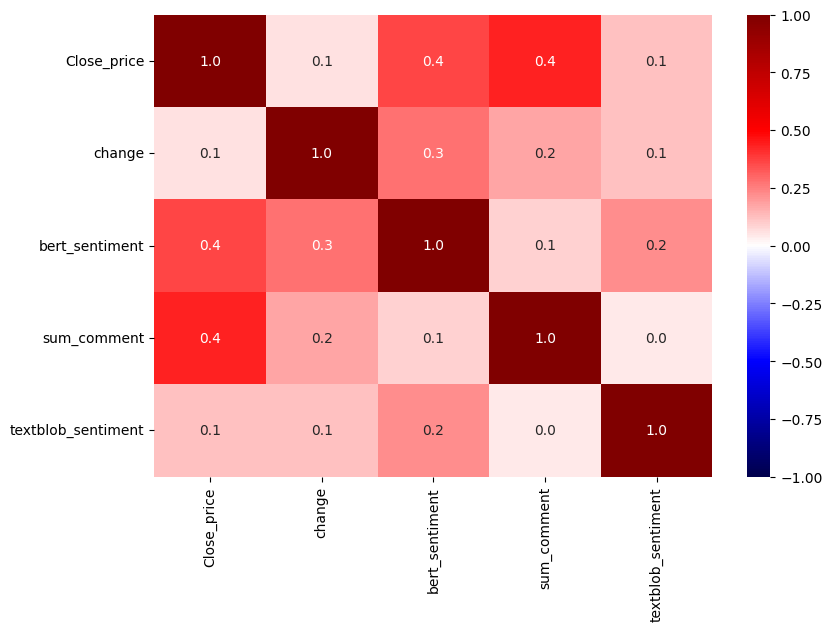

In [ ]:
plt.figure(figsize=[9,6])
sns.heatmap(result_df.corr(), cmap="seismic", annot=True, vmin=-1, vmax=1, fmt='.1f');

## **CREATING MY SENTIMENT ANALYSIS MODEL**

In [ ]:
result_sentiment

,date,body,clear comment,language,bert_clear_comment,textblob_sentiment_score,textblob_sentiment,bert_sentiment
0,2019-05-01,Coinbase requires a certain amount of confirma...,coinbase requires certain amount confirmation ...,eng,coinbase requires a certain amount of confirma...,0.214286,positive,neutral
1,2019-05-01,Roger Ver (or simply Roger): collective noun. ...,simply roger collective noun hater bitcoin ene...,eng,roger ver (or simply roger): collective noun. ...,0.000000,neutral,negative
2,2019-05-01,I watched the video 2 times. best bitcoin ad e...,watched video time best bitcoin ad ever,eng,i watched the video 2 times. best bitcoin ad e...,1.000000,positive,positive
3,2019-05-01,"Nano is my go to for P2P crypto right now, it'...",go p crypto right bitcoin supposed thing bothe...,eng,"nano is my go to for p2p crypto right now, it'...",0.285714,positive,negative
4,2019-05-01,&gt;Bakkt delays may have been a blessing in d...,delay may blessing disguise since avoided mass...,eng,&gt;bakkt delays may have been a blessing in d...,0.066667,positive,neutral
...,...,...,...,...,...,...,...,...
150118,2019-07-30,"In the end, you gotta spend money to get bitco...",end got ta spend money get bitcoin nano,eng,"in the end, you gotta spend money to get bitco...",0.000000,neutral,neutral
150119,2019-07-30,It's not as simple as that.\n\nI wrote an opin...,simple wrote opinion piece blog try explain ht...,eng,it's not as simple as that. i wrote an opinion...,-0.060000,negative,neutral
150120,2019-07-30,Buy Bitcoin.,buy bitcoin,eng,buy bitcoin.,0.000000,neutral,neutral
150121,2019-07-30,"While very fucking cool, I wish it was more in...",fucking cool wish informational advertising bi...,eng,"while very fucking cool, i wish it was more in...",0.350000,positive,positive


In [ ]:
# label encoder 
def encoder(text):
  if text=="positive":
    return 2
  elif text=="neutral":
    return 1
  else :
    return 0

In [ ]:
result_sentiment["bert_sentiment"] = result_sentiment["bert_sentiment"].apply(encoder)

In [ ]:
X = datacp["bert_clear_comment"]
y = datacp.bert_sentiment

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

tfidf2 = TfidfVectorizer(ngram_range=(1,2), binary=True, stop_words='english')
X_train_tfidf2 = tfidf2.fit_transform(X_train)
X_test_tfidf2  = tfidf2.transform(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

In [ ]:
lr = LogisticRegression()
lr.fit(X_train_tfidf, y_train)
y_pred_tfidf_lr = lr.predict(X_test_tfidf)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
lr = LogisticRegression()
lr.fit(X_train_tfidf2, y_train)
y_pred_tfidf2_lr = lr.predict(X_test_tfidf2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
def conf_matrix(actual, predicted):
    plt.figure(figsize=[8,8])
    cm = confusion_matrix(actual, predicted)
    sns.heatmap(cm, xticklabels=['Predicted Negative','Pedicted Neutral ', 'Predicted Positive'], 
                yticklabels=['Actual Negative','Actual Neutral', 'Actual Positive'], annot=True,
                fmt='d', annot_kws={'fontsize':35}, cmap="YlGnBu", square=True);

    accuracy = accuracy_score(actual, predicted)
    f1 = f1_score(actual, predicted, average='weighted')

    cm_results = [accuracy, f1]
    return cm_results

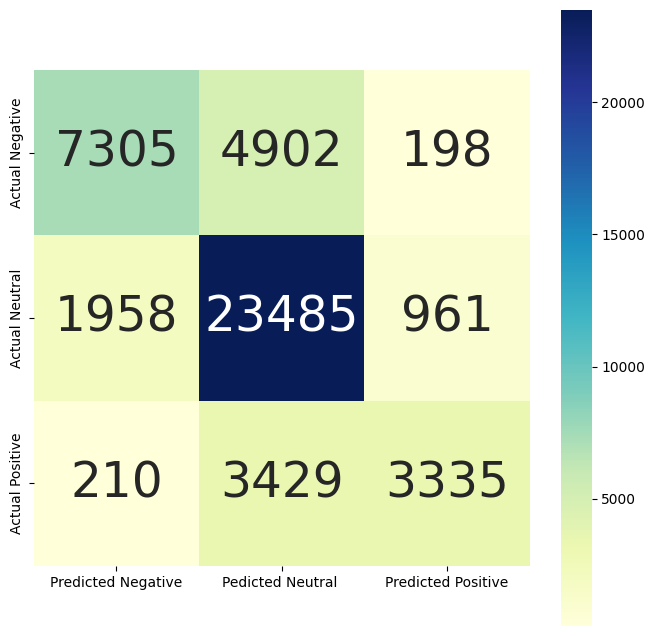

In [ ]:
cm1 = conf_matrix(y_test,y_pred_tfidf_lr)

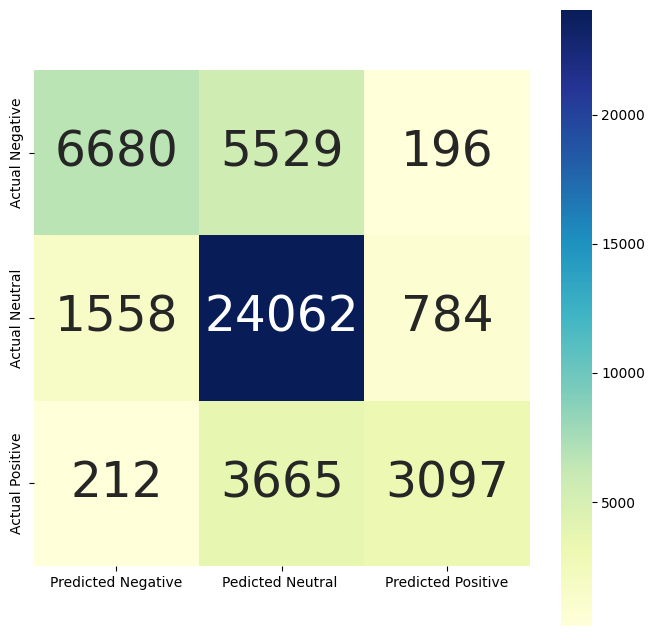

In [ ]:
cm2 = conf_matrix(y_test,y_pred_tfidf2_lr)

In [ ]:
from sklearn.naive_bayes import MultinomialNB

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf.toarray(), y_train)
y_pred_tfidf_mnb = mnb.predict(X_test_tfidf)

In [ ]:
mnb = MultinomialNB()
mnb.fit(X_train_tfidf2.toarray(), y_train)
y_pred_tfidf2_mnb = mnb.predict(X_test_tfidf2)

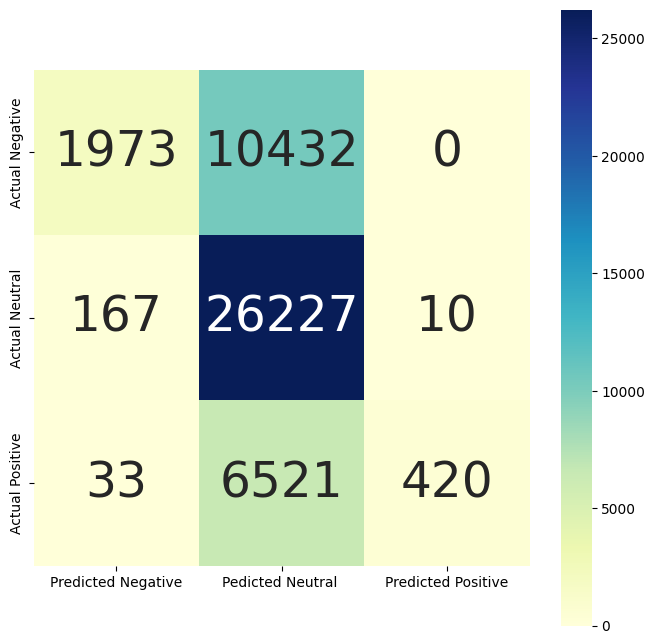

In [ ]:
cm3 = conf_matrix(y_test,y_pred_tfidf_mnb)

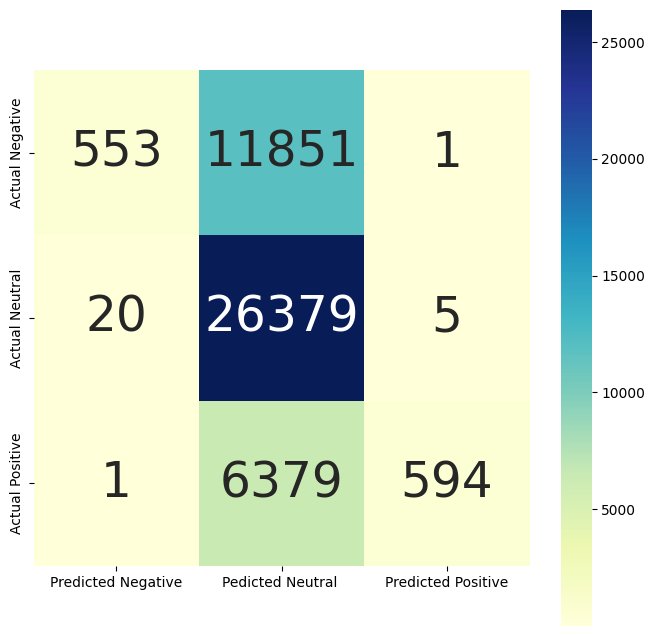

In [ ]:
cm4 = conf_matrix(y_test,y_pred_tfidf2_mnb)

In [ ]:
results_tf = pd.DataFrame(list(zip(cm1, cm2, cm3, cm4)))
results_tf = results_tf.set_index([['Accuracy', 'F1 Score']])
results_tf.columns = ['LR(Word)-TFIDF', 'LR(N-Grams)-TFIDF',
                      'MNB(Word)-TFIDF', 'MNB(N-Grams)-TFIDF']

In [ ]:
results_tf

,LR(Word)-TFIDF,LR(N-Grams)-TFIDF,MNB(Word)-TFIDF,MNB(N-Grams)-TFIDF
Accuracy,0.745364,0.739117,0.625123,0.601228
F1 Score,0.734816,0.724158,0.525369,0.475448


When examining the accuracy and F1 scores, it was evident that the logistic regression model with single unigram configurations yielded the most successful results. This indicates that the logistic regression model, trained on the single word features, achieved the highest accuracy and f1 score in predicting sentiment based on the input text.